In [1]:
# add local directory to import path
import os
import sys
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
#### --- Standard imports ------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from operator import attrgetter

from IPython.display import HTML

# local import
import nflplot
import nflutil

In [3]:
from importlib import reload
reload(nflplot)
reload(nflutil)

<module 'nflutil' from 'C:\\Users\\pschl\\Documents\\data_science\\kaggle_nfl_bdb_2022\\nflutil.py'>

**IMPORT DATA - This notebook assumes that the source data is in a "csv" subfolder relative to this notebook**

In [4]:
year = 2018
track_df = nflutil.transform_tracking_data(pd.read_csv(f'csv/tracking{year}.csv'))

In [5]:
play_df = pd.read_csv('csv/plays.csv')
game_df = pd.read_csv('csv/games.csv')
player_df = pd.read_csv('csv/players.csv')
pff_df = pd.read_csv('csv/PFFScoutingData.csv')

## Event Types

In [6]:
# play-level
play_df['specialTeamsPlayType'].value_counts()

Kickoff        7843
Punt           5991
Extra Point    3488
Field Goal     2657
Name: specialTeamsPlayType, dtype: int64

In [7]:
play_df.loc[play_df['specialTeamsPlayType']=='Punt', 'specialTeamsResult'].value_counts()

Return                      2286
Fair Catch                  1640
Downed                       829
Out of Bounds                586
Touchback                    383
Muffed                       154
Non-Special Teams Result      74
Blocked Punt                  39
Name: specialTeamsResult, dtype: int64

In [8]:
# get event counts for punt plays
pd.merge(
    track_df.groupby(['gameId','playId','frameId']).head(1),
    play_df[play_df['specialTeamsPlayType']=='Punt'],
    how='inner',
    on=['gameId','playId']
)['event'].value_counts()

None                        225312
ball_snap                     2136
punt                          2127
punt_received                  855
tackle                         707
first_contact                  621
fair_catch                     586
punt_land                      582
out_of_bounds                  378
punt_downed                    331
line_set                       153
touchback                      144
fumble_offense_recovered        53
punt_muffed                     52
fumble                          36
fumble_defense_recovered        31
punt_fake                       23
punt_blocked                    20
touchdown                       15
punt_play                       13
man_in_motion                   12
run                             12
penalty_flag                    11
pass_forward                    10
kick_received                    9
pass_arrived                     9
pass_outcome_caught              7
snap_direct                      4
pass_outcome_incompl

## Punt Formations - distribution of gunner count, vise count, and gunner-deficit (# gunners - # vises)

### Gunner Count

In [9]:
# total number of punt plays with data
pff_df[pff_df['kickType'].isin(['N','R','A'])].shape[0]

5880

In [10]:
# number of zero-gunner plays (max-protect)
pff_df[pff_df['gunners'].isna() 
       & (pff_df['kickType'].isin(['N','R','A']))].shape[0]

18

In [11]:
# number of gunners in plays where there are gunners
(pff_df.loc[pff_df['gunners'].notna() 
       & (pff_df['kickType'].isin(['N','R','A'])),
          'gunners']
  .transform(lambda x: x.count(';') + 1)
).value_counts().sort_index()

1      13
2    5809
3      33
4       7
Name: gunners, dtype: int64

The results above clearly show that 2 gunners is the vast majority of all scenarios, so any consideration of gunner count as a predictive feature should be investigated thoroughly.

### Vise Count

In [12]:
# number of zero-vise plays (block attempt)
pff_df[pff_df['vises'].isna() 
       & (pff_df['kickType'].isin(['N','R','A']))].shape[0]

40

In [13]:
# number of vises in plays where there are vises
(pff_df.loc[pff_df['vises'].notna() 
       & (pff_df['kickType'].isin(['N','R','A'])),
          'vises']
  .transform(lambda x: x.count(';') + 1)
).value_counts().sort_index()

1      61
2    3495
3    1746
4     531
5       7
Name: vises, dtype: int64

### Gunner deficit
Negative means less gunners than vises

In [14]:
def count_gunner_deficit(df):
    # counts gunner deficit (# gunners - # vises)
    # - if the type is not string, it is nan (float)
    gunners = 0 if type(df['gunners']) is not str else df['gunners'].count(';') + 1
    vises = 0 if type(df['vises']) is not str else df['vises'].count(';') + 1
    return gunners - vises

In [15]:
(pff_df[(pff_df['kickType'].isin(['N','R','A']))]
  .apply(lambda row: count_gunner_deficit(row), axis=1)
).value_counts().sort_index()

-3       4
-2     525
-1    1740
 0    3520
 1      70
 2      21
dtype: int64

## Relative position at catch
Get order of closest to furthest from returner at time of catch, then see which player makes the tackle
* Distribution of order vs tackler
* Distribution of space to closest defender (X yds) vs. player that makes tackle (1st, 2nd, ...)

In [16]:
# get the punt plays with a return
puntreturn_play_df = play_df.loc[(play_df['specialTeamsPlayType']=='Punt') & (play_df['specialTeamsResult']=='Return'), :]
len(puntreturn_play_df)

2286

In [17]:
puntreturn_play_df.iloc[0]

gameId                                                           2018090600
playId                                                                  366
playDescription           (9:20) C.Johnston punts 56 yards to ATL 36, Ce...
quarter                                                                   1
down                                                                      4
yardsToGo                                                                 4
possessionTeam                                                          PHI
specialTeamsPlayType                                                   Punt
specialTeamsResult                                                   Return
kickerId                                                              45603
returnerId                                                            42450
kickBlockerId                                                           NaN
yardlineSide                                                            PHI
yardlineNumb

In [18]:
gameId = 2018090600
playId = 366
(track_df[(track_df['gameId']==gameId)&(track_df['playId']==playId)&(track_df['event']!='None')]
 .groupby('frameId')
 .head(1)
 )[['frameId', 'event']]

,frameId,event
12070916,11,ball_snap
12070938,33,punt
12070983,78,punt_received
12071005,100,first_contact
12071024,119,tackle


In [19]:
def get_frame_of_event(track_df, event_name):
    # returns a dataframe of gameId, playId, frameId, and event name for the input event name.
    # track_df = tracking data, any number of plays
    return (track_df.loc[track_df.event==event_name,
                         ['gameId','playId','frameId','event']]
            .groupby(['gameId','playId', 'frameId'])
            .head(1)
           )

In [20]:
test_df = track_df[(track_df.gameId==gameId)&(track_df.playId==playId)]
get_frame_of_event(test_df, 'punt_received')

,gameId,playId,frameId,event
12070983,2018090600,366,78,punt_received


In [21]:
# limit to punt plays
play_punt_mask = ((play_df['specialTeamsPlayType']=='Punt') & 
                  (play_df['specialTeamsResult']=='Return') &
                  ~play_df['returnerId'].astype(str).str.contains(';')
                 )

rpac_df = (play_df.loc[play_punt_mask, ['gameId','playId','returnerId']]
 .astype({"returnerId": float})
 # attach the returner ID and frame ID of the "punt_received" event to each play
 .merge(get_frame_of_event(track_df, 'punt_received'),
        how='inner',
        on=['gameId','playId'])
 # get the returner position on the field when the punt is caught
 .merge(track_df[['gameId','playId','frameId','nflId','team','x','y']],
        how='inner',
        left_on=['gameId','playId','frameId','returnerId'],
        right_on=['gameId','playId','frameId','nflId'])
 .drop(columns=['nflId'])
 .rename(columns={'x':'x_returner', 'y':'y_returner', 'team':'teamReturner'})
 # attach home and away team labels for each game
 .merge(game_df[['gameId','homeTeamAbbr','visitorTeamAbbr']],
        how='inner',
        on='gameId')
 # attach the returner location to each opposing team player's position
 .merge(track_df[['gameId','playId','frameId','nflId','team','jerseyNumber','x','y']],
        how='inner',
        on=['gameId','playId','frameId'])
 .query('teamReturner != team and team != "football"')
 .astype({'jerseyNumber': int})
 # assemble identifier for punting team players
 .assign(puntTeamAbbr=lambda df_: np.where(df_['team']=='home', df_['homeTeamAbbr'], df_['visitorTeamAbbr']),
         jerseyID=lambda df_: df_['puntTeamAbbr'] + ' ' + df_['jerseyNumber'].astype(str).str.rjust(2, '0'))
 .drop(columns=['teamReturner', 'team', 'homeTeamAbbr', 'visitorTeamAbbr'])
 # calculate distance to returner
 .assign(dist=lambda df_: np.sqrt((df_['x']-df_['x_returner'])**2 + (df_['y']-df_['y_returner'])**2))
 # attach distance order within given play
 .sort_values(['gameId','playId','dist'])
 .assign(dist_order=lambda df_: df_.groupby(['gameId','playId']).cumcount()+1)
 # merge with PFF tackler data
 .merge(pff_df[['gameId','playId','tackler','kickContactType']].dropna(subset=['tackler']),
        how='inner',
        left_on=['gameId','playId','jerseyID'],
        right_on=['gameId','playId','tackler'])
 .merge(player_df[['nflId','displayName']],
        how='left',
        on='nflId')
 .query('kickContactType == "CC"')  # air clean catch
)

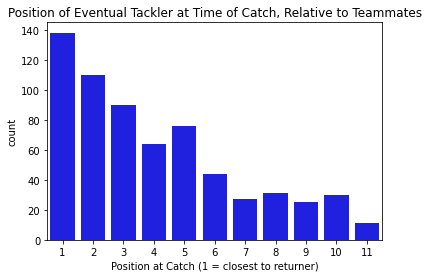

In [22]:
ax = sns.countplot(data=rpac_df, x='dist_order', color='blue')
_ = ax.set(xlabel='Position at Catch (1 = closest to returner)', title="Position of Eventual Tackler at Time of Catch, Relative to Teammates")

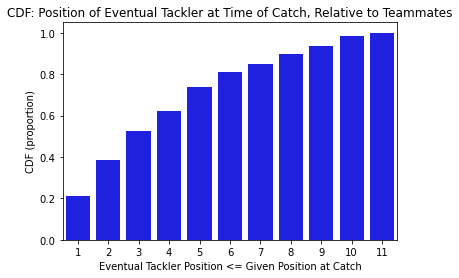

In [23]:
rpac_cdf = rpac_df.dist_order.value_counts().sort_index().cumsum() / len(rpac_df)
ax = sns.barplot(x=rpac_cdf.index, y=rpac_cdf.values, color='blue')
_ = ax.set(xlabel='Eventual Tackler Position <= Given Position at Catch', title="CDF: Position of Eventual Tackler at Time of Catch, Relative to Teammates",
           ylabel='CDF (proportion)')

In [24]:
rpac_cdf.values

array([0.21362229, 0.38390093, 0.52321981, 0.62229102, 0.73993808,
       0.80804954, 0.8498452 , 0.89783282, 0.93653251, 0.98297214,
       1.        ])

In [25]:
# numbers for CDF plot
rpac_df.dist_order.value_counts().sort_index().cumsum() / len(rpac_df)

1     0.213622
2     0.383901
3     0.523220
4     0.622291
5     0.739938
6     0.808050
7     0.849845
8     0.897833
9     0.936533
10    0.982972
11    1.000000
Name: dist_order, dtype: float64

The plots above show that the closest defenders at the time of the catch are most likely to be the ones who tackle the returner (as expected). The CDF plot shows that ~75% of returns with a tackle result in a tackle by one of the 5 closest players at the time of the catch.

### TEMP - function version

In [26]:
def get_defender_distances_at_catch(track_df, kickerId, returnerId):
    kicking_team = track_df.loc[track_df.nflId==kickerId, 'team'].iloc[0]
    if kicking_team == 'home':
        receiving_team = 'away'
    elif kicking_team == 'away':
        receiving_team = 'home'
    else:
        raise ValueError(f'Expected kicking team to be "home" or "away". Value was "{kicking_team}".')
    
    # get catch frameId
    catch_frame = get_frame_of_event(track_df, 'punt_received')
    
    # defender location at catch - 11x2 matrix (X,Y)
    defender_mask = (track_df.frameId==catch_frame) & (track_df.team==kicking_team)
    defender_xy = track_df.loc[defender_mask, ['x','y']].to_numpy()
    
    # returner location at catch - 1x2 matrix (X,Y)
    returner_mask = ((track_df.frameId==catch_frame)   # at the catch
                    &(track_df.nflId==returnerId))  # is the returner
    returner_xy = track_df.loc[returner_mask, ['x','y']].to_numpy().reshape(1,-1)
    
    # calculate the distance to the returner
    diff_xy = defender_xy - returner_xy 
    dist = np.linalg.norm(diff_xy, axis=1)
    
    return (track_df
           .loc[defender_mask, ['gameId','playId','nflId','displayName','jerseyNumber','position','team']]
           .assign(dist_to_returner = dist)
           .sort_values('dist_to_returner', ascending=True)
           .reset_index(drop=True)
           .assign(dist_order=lambda df_: df_.index + 1)
            )  
    
    

## Depth of punt returner at snap
Potential to determine whether to stratify short punts or not, depending on distribution

In [27]:
# limit to punt plays
play_punt_mask = ((play_df['specialTeamsPlayType']=='Punt') & 
                  ~play_df['returnerId'].astype(str).str.contains(';')
                 )

rpos_df = (play_df.loc[play_punt_mask, ['gameId','playId','returnerId']]
 .astype({"returnerId": float})
 .dropna(subset=['returnerId'])
 # attach the returner ID and frame ID of the "punt_received" event to each play
 .merge(nflutil.get_frame_of_event(track_df, 'ball_snap'),
        how='inner',
        on=['gameId','playId'])
 # get the returner position on the field when the punt is caught
 .merge(track_df[['gameId','playId','frameId','nflId','x']],
        how='inner',
        left_on=['gameId','playId','frameId','returnerId'],
        right_on=['gameId','playId','frameId','nflId'])
 .drop(columns=['nflId'])
 .rename(columns={'x':'x_returner'})
 # attach the football location
 .merge(track_df.loc[track_df.team == 'football', ['gameId','playId','frameId','x']],
        how='inner',
        on=['gameId','playId','frameId'])
 .rename(columns={'x': 'x_football'})
 # create a variable 0-100 for line of scrimmage on the field
 .assign(los_abs=lambda df_: df_.x_football - 10,
         returner_depth=lambda df_: df_.x_returner - df_.x_football,
         los_bin=lambda df_: pd.cut(df_.los_abs, range(0,101,5)),
         los_bin_mid=lambda df_: df_.los_bin.map(attrgetter('mid')))
)
rpos_df

,gameId,playId,returnerId,frameId,event,x_returner,x_football,los_abs,returner_depth,los_bin,los_bin_mid
0,2018090600,366,42450.0,11,ball_snap,67.05,17.90,7.90,49.15,"(5, 10]",7.5
1,2018090600,973,29957.0,11,ball_snap,68.89,20.80,10.80,48.09,"(10, 15]",12.5
2,2018090600,1989,29957.0,11,ball_snap,85.21,35.82,25.82,49.39,"(25, 30]",27.5
3,2018090600,2406,42450.0,11,ball_snap,99.66,51.57,41.57,48.09,"(40, 45]",42.5
4,2018090600,2599,29957.0,11,ball_snap,81.78,36.00,26.00,45.78,"(25, 30]",27.5
...,...,...,...,...,...,...,...,...,...,...,...
1440,2018123015,1714,43406.0,11,ball_snap,66.69,21.77,11.77,44.92,"(10, 15]",12.5
1441,2018123015,1958,43406.0,11,ball_snap,81.51,35.25,25.25,46.26,"(25, 30]",27.5
1442,2018123015,2277,43406.0,11,ball_snap,83.58,41.20,31.20,42.38,"(30, 35]",32.5
1443,2018123015,2395,42412.0,11,ball_snap,84.41,36.34,26.34,48.07,"(25, 30]",27.5


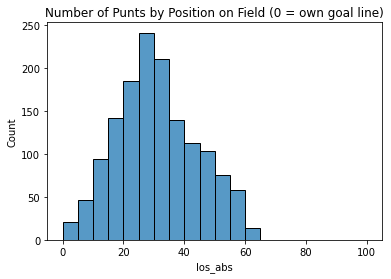

In [28]:
ax = sns.histplot(data=rpos_df, x='los_abs', binwidth=5, binrange=(0,100))
_ = ax.set(title='Number of Punts by Position on Field (0 = own goal line)')

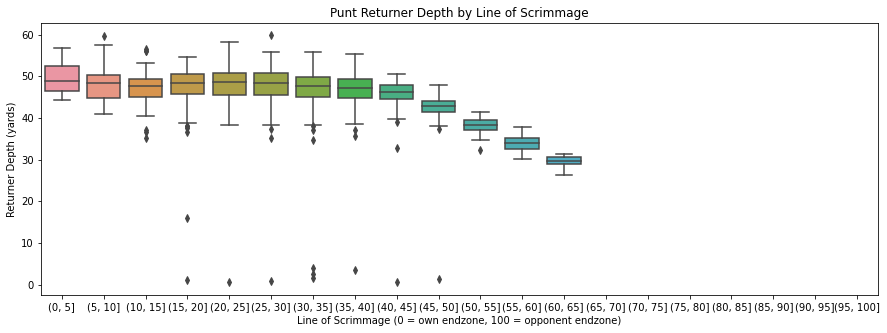

In [29]:
fig = plt.figure(figsize=(15,5))
ax = plt.gca()
sns.boxplot(ax=ax, data=rpos_df, x='los_bin', y='returner_depth')
_ = ax.set(title='Punt Returner Depth by Line of Scrimmage', 
           xlabel='Line of Scrimmage (0 = own endzone, 100 = opponent endzone)',
           ylabel='Returner Depth (yards)')

The plot above shows that the returner depth stays very consistent through the punting team's own 45 yard line, then decreases. If the modeling methodology requires accounting for the line of scrimmage/punt returner depth, it should investigate using a "short punt" flag as a feature (or depth of punt as a feature), or separate models for full-depth vs short-depth punts.